<a href="https://colab.research.google.com/github/123ranika/Research-paper/blob/main/Text_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
praveengovi_emotions_dataset_for_nlp_path = kagglehub.dataset_download('praveengovi/emotions-dataset-for-nlp')

print('Data source import complete.')


Data source import complete.


# 1. Import needed libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# 2. Read and Preprocessing data

### 2.1 Read data

In [49]:
df = pd.read_csv("/content/Traning.xlsx - Sheet1 (6) (2).csv")
val_df = pd.read_csv("/content/Val.xlsx - Sheet1 (2) (1).csv")
ts_df = pd.read_csv("/content/Test.xlsx - Sheet1 (2) (1).csv")

In [50]:
df

,PID,text,labels
0,1,সীমালঙ্ঘন কারীকে আল্লাহ ক্ষমা করেন না,Religious_Hatred
1,2,বর্ণবাদী হলে কি কফির রঙও আপনাকে বিরক্ত করবে?,Racism
2,3,এই ধর্মের জন্য সমাজে কোনো উন্নতি নেই।,Religious_Hatred
3,4,জিবনে কি বালডা ছিরলাম,Cyberbullying
4,5,"টিকটকার রাই সুখে আছে, না আছে ব্রেইন না আছে ব্র...",Sarcasm
...,...,...,...
5995,5996,রঙিন চশমা পরে সব শুধু বিম্পি,Political
5996,5997,"111. মেয়েরা শুধু সাজসজ্জার জন্য, অফিসের কাজে ...",Gender_Discrimination
5997,5998,আপু ভুড়ি কমান দেখতে বাজে লাগে,Racism
5998,5999,গরুর গোবর আর পেসাব খাওয়া জাতির মাথায় এর চেয়ে ...,Racism


In [51]:
df['labels'].unique()

array(['Religious_Hatred', 'Racism', 'Cyberbullying', 'Sarcasm',
       'Gender_Discrimination', 'Political', nan], dtype=object)

In [52]:
df.labels.value_counts()

,count
labels,
Cyberbullying,1686
Sarcasm,1518
Political,776
Gender_Discrimination,678
Religious_Hatred,673
Racism,668


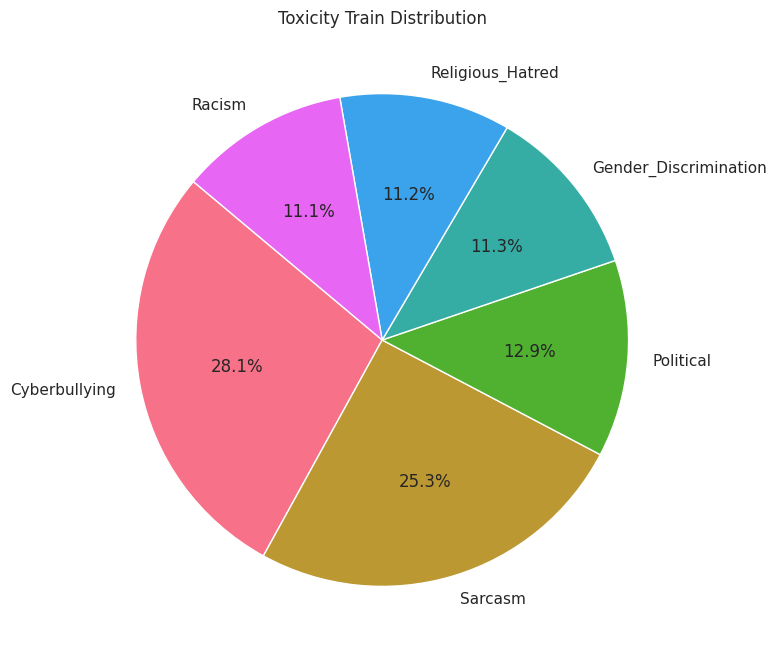

In [53]:
# Count label distributions
label_counts = df['labels'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Toxicity Train Distribution')
plt.show()

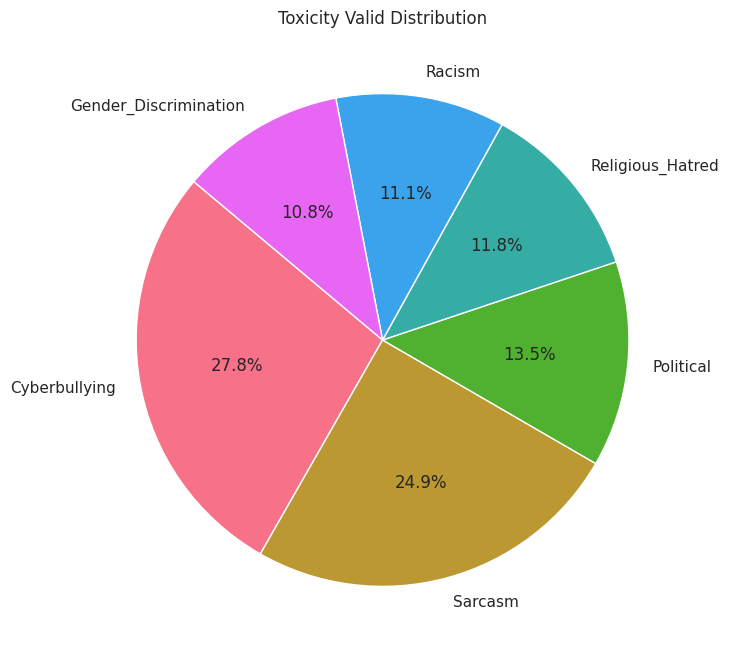

In [54]:
label_counts = val_df['labels'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Toxicity Valid Distribution')
plt.show()

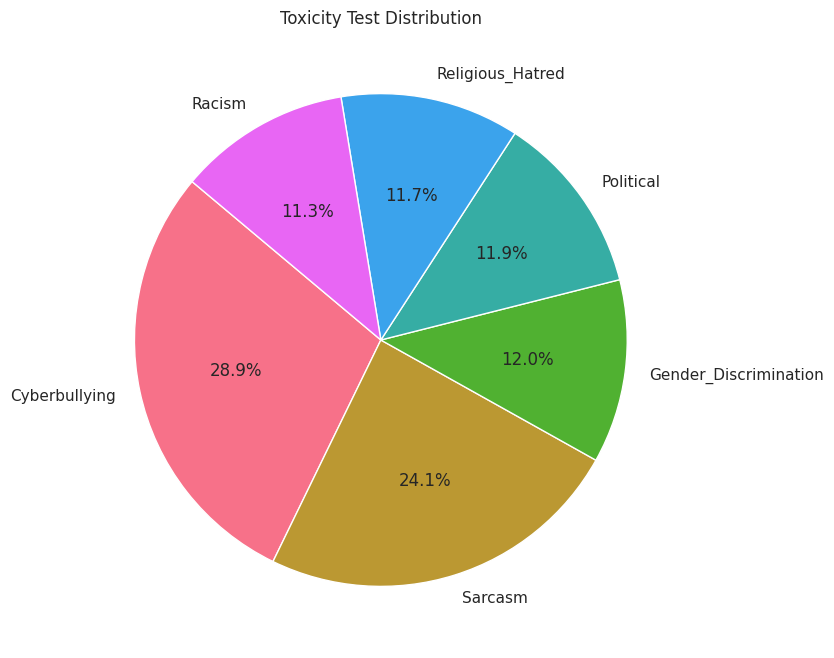

In [55]:
# Count label distributions
label_counts = ts_df['labels'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Toxicity Test Distribution')
plt.show()

### Since we have an unbalanced dataset, we can remove both surprise and love labels since they are the lowest and reduce each label to make the dataset balanced.

In [56]:
df = df[~df['labels'].str.contains('Cyberbullying', na=False)]
df = df[~df['labels'].str.contains('Religious_Hatred', na=False)]
df = df[~df['labels'].str.contains('Racism', na=False)]
df = df[~df['labels'].str.contains('Sarcasm', na=False)]
df = df[~df['labels'].str.contains('Gender_Discrimination', na=False)]
df = df[~df['labels'].str.contains('Political', na=False)]

In [57]:
# Reset the DataFrame to the original before filtering
df = pd.read_csv("/content/Traning.xlsx - Sheet1 (6) (2).csv") # Re-read the data to reset the DataFrame

# Remove trailing commas to assign DataFrames instead of tuples
Cyberbullying = df[df['labels'] == 'Cyberbullying'].sample(n=1600, random_state=20)
Religious_Hatred = df[df['labels'] == 'Religious_Hatred'].sample(n=673, random_state=20)
Racism = df[df['labels'] == 'Racism'].sample(n=600, random_state=20)
Gender_Discrimination = df[df['labels'] == 'Gender_Discrimination'].sample(n=600, random_state=20)
Political = df[df['labels'] == 'Political'].sample(n=750, random_state=20)
Sarcasm = df[df['labels'] == 'Sarcasm'].sample(n=1500, random_state=20)


df_sampled = pd.concat([Cyberbullying,Sarcasm,  Racism, Gender_Discrimination,Sarcasm,Political])

df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [58]:
df.labels.value_counts()

,count
labels,
Sarcasm,3000
Cyberbullying,1600
Political,750
Gender_Discrimination,600
Racism,600


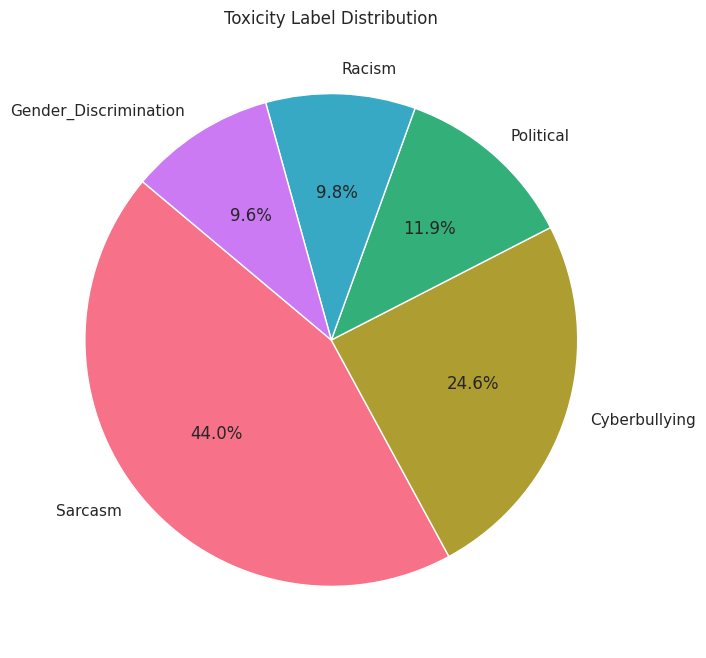

In [72]:
# Count label distributions
label_counts = df['labels'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Toxicity Label Distribution')
plt.show()

In [60]:
val_df.labels.value_counts()

,count
labels,
Cyberbullying,557
Sarcasm,498
Political,270
Religious_Hatred,236
Racism,222
Gender_Discrimination,217


In [87]:
val_df = df[~df['labels'].str.contains('Cyberbullying', na=False)]
val_df = df[~df['labels'].str.contains('Religious_Hatred', na=False)]
val_df = df[~df['labels'].str.contains('Racism', na=False)]
val_df = df[~df['labels'].str.contains('Sarcasm', na=False)]
val_df = df[~df['labels'].str.contains('Gender_Discrimination', na=False)]
val_df = df[~df['labels'].str.contains('Political', na=False)]

In [88]:
df = pd.read_csv("/content/Val.xlsx - Sheet1 (2) (1).csv") # Re-read the data to reset the DataFrame


Cyberbullying = df[df['labels'] == 'Cyberbullying'].sample(n=557, random_state=20)
Religious_Hatred = df[df['labels'] == 'Religious_Hatred'].sample(n=236, random_state=20)
Racism = df[df['labels'] == 'Racism'].sample(n=222, random_state=20)
Gender_Discrimination = df[df['labels'] == 'Gender_Discrimination'].sample(n=217, random_state=20)
Political = df[df['labels'] == 'Political'].sample(n=270, random_state=20)
Sarcasm = df[df['labels'] == 'Sarcasm'].sample(n=498, random_state=20)

df_sampled = pd.concat([Cyberbullying,Sarcasm,  Racism, Gender_Discrimination,Sarcasm,Political])

val_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

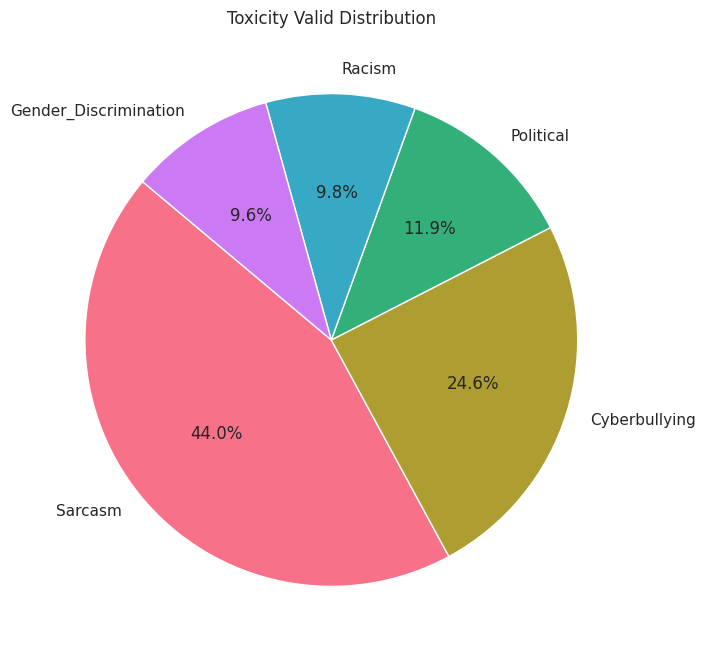

In [89]:
# Count label distributions
label_counts = val_df['labels'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Toxicity Valid Distribution')
plt.show()

In [84]:
ts_df.labels.value_counts()

,count
labels,
Sarcasm,964
Cyberbullying,578
Gender_Discrimination,241
Political,238
Racism,226


In [90]:
ts_df = df[~df['labels'].str.contains('Cyberbullying', na=False)]
ts_df = df[~df['labels'].str.contains('Religious_Hatred', na=False)]
ts_df = df[~df['labels'].str.contains('Racism', na=False)]
ts_df = df[~df['labels'].str.contains('Sarcasm', na=False)]
ts_df = df[~df['labels'].str.contains('Gender_Discrimination', na=False)]
ts_df = df[~df['labels'].str.contains('Political', na=False)]

In [91]:
df = pd.read_csv("/content/Test.xlsx - Sheet1 (2) (1).csv") # Re-read the data to reset the DataFrame


Cyberbullying = df[df['labels'] == 'Cyberbullying'].sample(n=578, random_state=20)
Religious_Hatred = df[df['labels'] == 'Religious_Hatred'].sample(n=235, random_state=20)
Racism = df[df['labels'] == 'Racism'].sample(n=226, random_state=20)
Gender_Discrimination = df[df['labels'] == 'Gender_Discrimination'].sample(n=241, random_state=20)
Political = df[df['labels'] == 'Political'].sample(n=238, random_state=20)
Sarcasm = df[df['labels'] == 'Sarcasm'].sample(n=482, random_state=20)

df_sampled = pd.concat([Cyberbullying,Sarcasm,  Racism, Gender_Discrimination,Sarcasm,Political])

ts_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

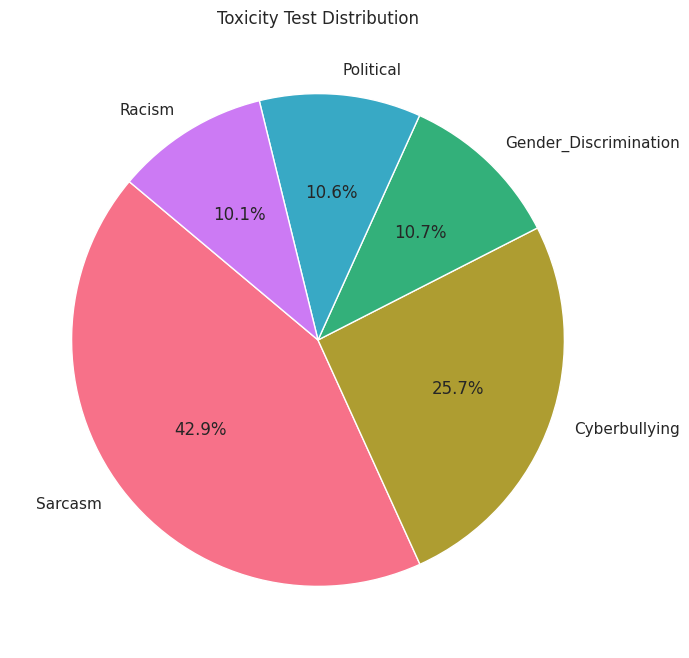

In [92]:
# Count label distributions
label_counts = ts_df['labels'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Toxicity Test Distribution')
plt.show()

### 2.2 Split data into X, y

In [93]:
tr_text = df['text']
tr_label = df['labels']

val_text = val_df['text']
val_label = val_df['labels']

ts_text = ts_df['text']
ts_label = ts_df['labels']

### 2.3 Encoding

In [94]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

### 2.4 Text preprocessing

In [106]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text)

sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=50)
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label)

# 3. Building deep learning model

In [96]:
max_words = 10000
max_len = 50
embedding_dim = 32

### 3.1 Model architecture

In [109]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(4, activation='softmax')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

ValueError: The layer sequential_7 has never been called and thus has no defined input.

In [100]:
model = Sequential()
model.add(Embedding(10000, 32, input_length=50))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(.5))
model.add(GlobalMaxPooling1D(keepdims=True))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(6, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### 3.2 Compile model

In [101]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [102]:
# GlobalMaxPooling1D??

### 3.3 Traning the model

In [103]:
batch_size = 256
epochs = 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y))

Epoch 1/25


AttributeError: Exception encountered when calling Embedding.call().

[1m'tuple' object has no attribute 'dtype'[0m

Arguments received by Embedding.call():
  • inputs=('tf.Tensor(shape=(None, 50), dtype=int32)', 'tf.Tensor(shape=(None, 50), dtype=int32)')

# 4. Evaluation and Visullize results

### 4.1 Evaluate the model

In [104]:
(loss, accuracy, percision, recall) = model.evaluate([tr_x, tr_x], tr_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

AttributeError: Exception encountered when calling Embedding.call().

[1m'tuple' object has no attribute 'dtype'[0m

Arguments received by Embedding.call():
  • inputs=('tf.Tensor(shape=(None, 50), dtype=int32)', 'tf.Tensor(shape=(None, 50), dtype=int32)')

In [ ]:
(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

In [ ]:
history.history.keys()

### 4.2 Visullize results

In [105]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision']
tr_recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision']
val_recall = history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

NameError: name 'history' is not defined

In [ ]:
y_true=[]
for i in range(len(ts_y)):

    x = np.argmax(ts_y[i])
    y_true.append(x)

In [ ]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
y_pred

In [ ]:
plt.figure(figsize=(8,6))
emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'sadness'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

In [ ]:
clr = classification_report(y_true, y_pred)
print(clr)

# 5. Save model

In [ ]:
import pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('nlp.h5')

# 6. Prediction function

In [ ]:
def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import matplotlib.pyplot as plt
    import pickle
    from tensorflow.keras.models import load_model

    model = load_model(model_path)


    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)

    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=50)
    predictions = model.predict([x_new, x_new])

    emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'sadness'}

    label = list(emotions.values())
    probs = list(predictions[0])
    labels = label
    plt.subplot(1, 1, 1)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [ ]:
txt = 'I am very happy to finish this project'
predict(txt, 'nlp.h5', 'tokenizer.pkl')

In [ ]:
txt = 'I am very sad'
predict(txt, 'nlp.h5', 'tokenizer.pkl')

In [ ]:
txt = 'Ahhhhhhhhhhhh, I wanna kill myself.'
predict(txt, 'nlp.h5', 'tokenizer.pkl')

In [ ]:
txt = 'I think, i am afraid.'
predict(txt, 'nlp.h5', 'tokenizer.pkl')